In [2]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from torch import Tensor
from typing import Callable, Optional
import torch.nn.functional as F
from torch import nn

In [3]:
df_ETTh1 = pd.read_csv("/scratch/ab10445/hpml/PatchTST/dataset/ETT-small/ETTh1.csv")
print(df_ETTh1.head())

                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [4]:
df_ETTh1.iloc[:,1:].shape, df_ETTh1.shape, 12 * 30 * 24

((17420, 7), (17420, 8), 8640)

In [5]:
class ETTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset="ETTh1", mode="train", scale=True, seq_len=336, pred_len=96):
        super().__init__()
        df = pd.read_csv("/scratch/ab10445/hpml/PatchTST/dataset/ETT-small/ETTh1.csv".format(dataset))
        x_y = df.iloc[:,1:]
        time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]
        
        self.seq_len = seq_len
        self.pred_len = pred_len

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if scale:
            train_x_y = x_y.iloc[border1s[0]: border2s[0]]
            self.ss = StandardScaler()
            self.ss.fit(train_x_y.to_numpy(dtype=np.float32))
            x_y = self.ss.transform(x_y.to_numpy(dtype=np.float32))
        else:
            x_y = x_y.to_numpy(dtype=np.float32)
        
        time_stamp = time_stamp.to_numpy()     
        
        self.data_x = x_y[border1: border2, :]
        self.data_y = x_y[border1: border2, -1]

        self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.ss.inverse_transform(data)

In [6]:
#Revin.py
class RevIN(torch.nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            # print(f'x.mT.shape: {x.mT.shape} | self.affine_weight: {self.affine_weight.shape}')
            x = x * self.affine_weight + self.affine_bias
            # print(f'x.shape: {x.shape} | self.affine_weight: {self.affine_bias.shape}')
            # x = x + self.affine_bias
        return x.mT

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

In [7]:
#PatchTST_layers.py
class Transpose(torch.nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

In [8]:
#PatchTST_backbone.py
class TSTiEncoder(torch.nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=128, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True, verbose=False, **kwargs):
                 #act="gelu" 
        
        
        super().__init__()
        
        self.patch_num = patch_num
        self.patch_len = patch_len
        
        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)

        
    def forward(self, x) -> Tensor:                                              # x: [bs x nvars x patch_len x patch_num]
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]
        
        return z         
            
    
# Cell
class TSTEncoder(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, 
                        norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu',
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=activation, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:Tensor, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=128, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias),
                                torch.nn.GELU(),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src
        

In [9]:
class _MultiheadAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        """Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x d_model]
            K, V:    [batch_size (bs) x q_len x d_model]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))


    def forward(self, Q:Tensor, K:Optional[Tensor]=None, V:Optional[Tensor]=None, prev:Optional[Tensor]=None,
                key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [10]:
class _ScaledDotProductAttention(torch.nn.Module):
    r"""Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)"""

    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q:Tensor, k:Tensor, v:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [11]:
class Flatten_Head(torch.nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        
        self.individual = individual
        self.n_vars = n_vars
        
        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2)) #flattens last 2
                self.linears.append(nn.Linear(nf, target_window))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, target_window)
            self.dropout = nn.Dropout(head_dropout)
            
    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:,i,:,:])          # z: [bs x d_model * patch_num]
                z = self.linears[i](z)                    # z: [bs x target_window]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)                 # x: [bs x nvars x target_window]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x

#Implementation of PatchTST
def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

class PatchTST(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, max_seq_len:Optional[int]=1024, 
                 n_layers=3, d_model=128, n_heads=4, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=128, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0.3, act:str="gelu", key_padding_mask:bool='auto',
                 padding_var:Optional[int]=None, attn_mask:Optional[Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, fc_dropout:float=0.3, head_dropout = 0, padding_patch = None,
                 pretrain_head:bool=False, head_type = 'flatten', individual = False, revin = True, affine = True, subtract_last = False,
                 verbose:bool=False, **kwargs):
        
        super().__init__()
        
        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)
        
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride)) 
            patch_num += 1
        
        # Backbone 
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pe, verbose=verbose, **kwargs)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        if self.pretrain_head: 
            self.head = self.create_pretrain_head(self.head_nf, c_in, fc_dropout) # custom head passed as a partial func with all its kwargs
        elif head_type == 'flatten': 
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)
        
    
    def forward(self, z):                                                                   # z: [bs x nvars x seq_len]
        # norm
        if self.revin: 
            # z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            # z = z.permute(0,2,1)
            
        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        # print(f'z.shape: {z.shape}')
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]
        
        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x nvars x target_window] 
        
        # denorm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            # z = z.permute(0,2,1)
        return z
    
    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout),
                    nn.Conv1d(head_nf, vars, 1)
                    )

In [12]:
#Linear model
class Linear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        self.c_in = c_in
        self.context_winsoq = context_window
        self.target_window = target_window

        self.flatten = torch.nn.Flatten(start_dim=-2)

        self.linear = torch.nn.Linear(c_in * context_window, target_window)
    
    def forward(self, x):                   # x: [bs x seq_len × nvars]
        x = self.flatten(x)                 # x: [bs x seq_len * nvars]
        x = self.linear(x)                  # x: [bs x target_window]
        return x
    

class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.flatten_Seasonal = torch.nn.Flatten(start_dim=-2)
        self.flatten_Trend = torch.nn.Flatten(start_dim=-2)
        
        self.Linear_Seasonal = torch.nn.Linear(c_in * context_window, target_window)
        self.Linear_Trend = torch.nn.Linear(c_in * context_window, target_window)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init = self.flatten_Seasonal(x)
        trend_init = self.flatten_Trend(x)

        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x

In [13]:
class Learner:
    def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, target_window=96, d_model=16, adjust_lr=True, adjust_factor=0.001):
        self.model = model.to("cuda")
        self.batch_size = batch_size
        train_dataset = dataset(mode="train")
        valid_dataset = dataset(mode="val")
        test_dataset = dataset(mode="test")
        self.train_datalen = len(train_dataset)
        self.valid_datalen = len(valid_dataset)
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.lr=lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        self.epochs = epochs
        self.target_window=target_window
        self.best_weight = self.model.state_dict()
        self.d_model=d_model
        self.adjust_lr = adjust_lr
        self.adjust_factor = adjust_factor
    
    def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout: 
            print('Updating learning rate to {}'.format(lr_adjust))
        return 

    def train(self):
        best_valid_loss = np.inf
        train_history = []
        valid_history = []
        train_steps = 1
        if self.adjust_lr:
            self.adjust_learning_rate(train_steps)
        for epoch in range(self.epochs):
            #train
            self.model.train()
            iter_count = 0
            total_loss = 0

            for train_x, train_y in self.train_dataloader:
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")
                # print(f'train_x.shape: {train_x.shape}')
                pred_y = self.model(train_x)
                pred_y = pred_y[:, -self.target_window:, -1:].squeeze(-1)
                loss = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                iter_count += 1
                train_steps += 1
            if self.adjust_lr:
                self.adjust_learning_rate(train_steps)

            #valid
            self.model.eval()
            valid_iter_count = 0
            valid_total_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.model(valid_x)
                    pred_y = pred_y[:, -self.target_window:, -1:].squeeze(-1)
                    loss = self.loss(pred_y, valid_y)
                    valid_total_loss += loss.item()
                    valid_iter_count += 1
            
            total_loss /= iter_count
            valid_total_loss /= valid_iter_count
            print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
            if best_valid_loss >= valid_total_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = valid_total_loss
                print("Best score! Weights of the model are updated!")
            train_history.append(total_loss)
            valid_history.append(valid_total_loss)
        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0
        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x.to("cuda")
                test_y = test_y.to("cuda")
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1
        total_loss /= iter_count
        print("MSE test loss: {:.4f}".format(total_loss))



In [14]:
class Learner_2:
    def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, target_window=96, d_model=16, adjust_lr=True, adjust_factor=0.001):
        self.model = model.to("cuda")
        self.batch_size = batch_size
        train_dataset = dataset(mode="train")
        valid_dataset = dataset(mode="val")
        test_dataset = dataset(mode="test")
        self.train_datalen = len(train_dataset)
        self.valid_datalen = len(valid_dataset)
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.lr=lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        self.epochs = epochs
        self.target_window=target_window
        self.best_weight = self.model.state_dict()
        self.d_model=d_model
        self.adjust_lr = adjust_lr
        self.adjust_factor = adjust_factor
    
    def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout: 
            print('Updating learning rate to {}'.format(lr_adjust))
        return 

    def train(self):
        best_valid_loss = np.inf
        train_history = []
        valid_history = []
        train_steps = 1
        if self.adjust_lr:
            self.adjust_learning_rate(train_steps)
        for epoch in range(self.epochs):
            #train
            self.model.train()
            iter_count = 0
            total_loss = 0

            for train_x, train_y in self.train_dataloader:
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")
                # print(f'train_x.shape: {train_x.shape}')
                pred_y = self.model(train_x)
                # pred_y = pred_y[:, -self.target_window:, -1:].squeeze(-1)
                loss = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                iter_count += 1
                train_steps += 1
            if self.adjust_lr:
                self.adjust_learning_rate(train_steps)

            #valid
            self.model.eval()
            valid_iter_count = 0
            valid_total_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.model(valid_x)
                    # pred_y = pred_y[:, -self.target_window:, -1:].squeeze(-1)
                    loss = self.loss(pred_y, valid_y)
                    valid_total_loss += loss.item()
                    valid_iter_count += 1
            
            total_loss /= iter_count
            valid_total_loss /= valid_iter_count
            print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
            if best_valid_loss >= valid_total_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = valid_total_loss
                print("Best score! Weights of the model are updated!")
            train_history.append(total_loss)
            valid_history.append(valid_total_loss)
        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0
        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x.to("cuda")
                test_y = test_y.to("cuda")
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1
        total_loss /= iter_count
        print("MSE test loss: {:.4f}".format(total_loss))



In [15]:
c_in = 7
context_window = 336
target_window = 96
patch_len = 16
stride = 8 

patchtst_model = PatchTST(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride)

Linear_model = Linear(c_in=c_in, context_window=context_window, target_window=target_window)
DLinear_model = DLinear(c_in=c_in, context_window=context_window, target_window=target_window)

Linear_learner = Learner_2(model=Linear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01)
DLinear_learner = Learner_2(model=DLinear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01)
patchtst_learner = Learner(model=patchtst_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.001)

Linear_train_history, Linear_valid_history = Linear_learner.train()
DLinear_train_history, DLinear_valid_history = DLinear_learner.train()
# import torch.autograd.profiler as profiler

import time

start_time = time.perf_counter()

# with profiler.profile(record_shapes=True, use_cuda=True) as prof:
patchtst_train_history, patchtst_valid_history = patchtst_learner.train()

end_time = time.perf_counter()
elapsed_time = end_time - start_time

print("Elapsed Time:", elapsed_time)
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))



Updating learning rate to 4.811252243246882e-07
Updating learning rate to 3.1754264805429416e-05
epoch: 0 MSE loss: 1.2979 MSE valid loss: 0.8108
Best score! Weights of the model are updated!
Updating learning rate to 6.302740438653415e-05
epoch: 1 MSE loss: 0.6081 MSE valid loss: 0.7448
Best score! Weights of the model are updated!
Updating learning rate to 9.430054396763888e-05
epoch: 2 MSE loss: 0.3239 MSE valid loss: 0.6305
Best score! Weights of the model are updated!
Updating learning rate to 0.00012557368354874362
epoch: 3 MSE loss: 0.2492 MSE valid loss: 0.4601
Best score! Weights of the model are updated!
Updating learning rate to 0.00013846219390542782
epoch: 4 MSE loss: 0.2122 MSE valid loss: 0.3251
Best score! Weights of the model are updated!
Updating learning rate to 0.0001264304343560434
epoch: 5 MSE loss: 0.1892 MSE valid loss: 0.2723
Best score! Weights of the model are updated!
Updating learning rate to 0.00011707322644771175
epoch: 6 MSE loss: 0.1774 MSE valid loss: 

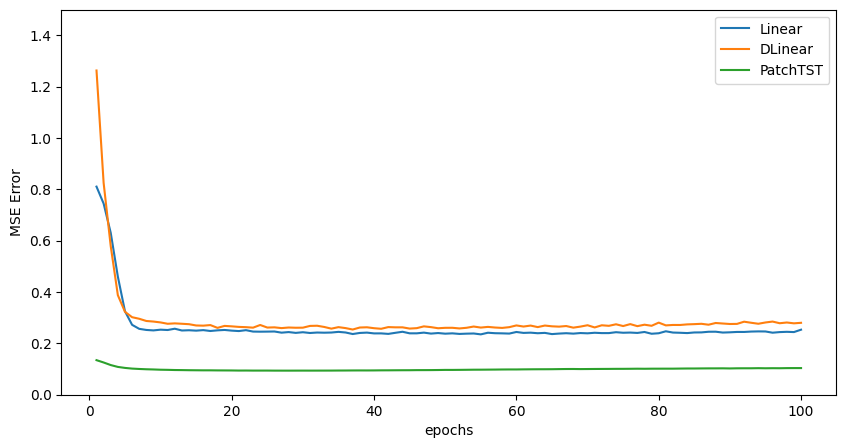

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, Linear_learner.epochs+1), Linear_valid_history, label="Linear")
ax.plot(np.arange(1, DLinear_learner.epochs+1), DLinear_valid_history, label="DLinear")
ax.plot(np.arange(1, patchtst_learner.epochs+1), patchtst_valid_history, label="PatchTST")
ax.set_xlabel("epochs")
ax.set_ylabel("MSE Error")
ax.set_ylim(0, 1.5)
ax.legend()
fig.show()

In [17]:
model = patchtst_model
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 3.096MB
